<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/APTorch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the first half of the notebook we will discuss:

1.
Primary setup of Rnn architecture

2.
Experiment with RNN on a few text based use cases

## Application of RNN for classification

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [129]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3ff64eabfbf8a35cc79cdbbab03c256574062596e21e101c89833ba6924f8425
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext import data
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchsummary import summary
from torchview import draw_graph
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 10
lr = 1e-3

Random seed set as 42
cuda


In [6]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


#### DataPrep- Same process as that of session-4

In [7]:
# get train and testset
train_dataset, test_dataset  = datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [8]:
# we wil use advanced tokenizer provided by torch
tokenizer = get_tokenizer("basic_english")
print(tokenizer("You can now install TorchText using pip!"))

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']


In [9]:
def build_vocab_iter(datasets):
  """yields tokenized text """
  for dataset in datasets:
    for _, text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab_iter([train_dataset, test_dataset]), specials=["<unk>"]) # build vocab from an iterator
vocab.set_default_index(vocab["<unk>"]) # anything unk will be have a default index

#### Dataloader

In [10]:
def vectorize_batch(batch):
  """Vectorize the batch and used in dataloader"""
  Y,X  = list(zip(*batch))
  X=[vocab(tokenizer(sample)) for sample in X]

  X = [sample+([0]* (50-len(sample))) if len(sample) < 50 else sample[:50] for sample in X] ## Bringing all samples to 50 length ie standardization of length

  Y = [0 if y==0 else y-1 for y in Y] # converting label starting form 0

  return torch.tensor(X, dtype=torch.int64).to(device), torch.tensor(Y, dtype=torch.int64).to(device)

In [11]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=vectorize_batch)

In [12]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


#### Basic RNN Classifier

This section describes the construction of a neural network for text classification, comprising three layers:

Embeddings Layer: This layer maps input token indexes to embedding vectors. The embeddings have a length of 50, meaning each token is represented by a 50-dimensional vector. During training, these embeddings are updated to improve document classification. The input shape is (batch_size, 25), and the output shape is (batch_size, 25, 50).

RNN Layer: Taking input from the embedding layer, this recurrent layer processes sequences of embeddings and generates outputs that encode contextual information about the text. It operates on the input shape of (batch_size, 25, 50) and produces an output shape of (batch_size, 25, hidden_size), where the hidden_size is set to 50 in this example. The RNN layer iterates through each token's embedding, producing an output that becomes the input for the next token. The initial state for each example is provided, typically as random numbers, and this process repeats for each text example.

Linear Layer: Finally, the output of the RNN layer is fed into a linear layer with four output units, corresponding to the number of target classes. Only the last output of each example (output[:,-1]) is used because the RNN layer contains information about all previous tokens. Thus, the input shape for the linear layer is (batch_size, 50). The RNN output shape of (batch_size, 25, 50) is transformed to (batch_size, 50) to fit the linear layer input.

The entire process involves sequential processing of embeddings through the RNN layer, with the final output used for classification. PyTorch's 'nn' submodule provides constructors like RNN() to create recurrent layers, allowing customization of input shape, hidden dimensions, and the number of layers.

In [45]:
# basic config
n_embedding = 50
n_hidden = 50
n_layers = 1

In [54]:
class BasicRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):

    super(BasicRnnClassifier, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.rnn = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)


  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    x, hidden = self.rnn(x, torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device) ) #(1,1024,50)
    x = self.fc(x[:,-1]) # we only need the last op
    return x



In [55]:
basic_rnn = BasicRnnClassifier(n_embedding, n_hidden, len(target_classes), n_layers)
basic_rnn = basic_rnn.to(device)

In [56]:
# input_batch = torch.randint(0, len(vocab), (batch_size, 50)).long().to(device)  # Convert to Long type and move to device
# summary(basic_rnn, input_batch.unsqueeze(0).shape,1)

In [57]:
for layer in basic_rnn.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print("\n")

Layer : Embedding(98635, 50)
Parameters : 
torch.Size([98635, 50])


Layer : Dropout(p=0.1, inplace=False)
Parameters : 


Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])


Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])




In [58]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=-1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [59]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=-1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [60]:
# driver setup
optimizer = optim.Adam(basic_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [61]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(basic_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(basic_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.385883643465527 Avg Train Metric: 0.25994146122770795: 100%|██████████| 118/118 [00:05<00:00, 20.87it/s]
Avg Test Loss: 1.3797128796577454 Avg Test Metric: 0.2835151366889477: 100%|██████████| 8/8 [00:00<00:00, 26.89it/s]


Epoch 1


Avg Train Loss: 1.2777627292325942 Avg Train Metric: 0.32437623001761356: 100%|██████████| 118/118 [00:06<00:00, 18.55it/s]
Avg Test Loss: 1.1623207777738571 Avg Test Metric: 0.450627651065588: 100%|██████████| 8/8 [00:00<00:00, 28.20it/s]


Epoch 2


Avg Train Loss: 1.0616298944263134 Avg Train Metric: 0.4628704715583284: 100%|██████████| 118/118 [00:05<00:00, 20.01it/s]
Avg Test Loss: 1.0151132345199585 Avg Test Metric: 0.5039648190140724: 100%|██████████| 8/8 [00:00<00:00, 27.56it/s]


Epoch 3


Avg Train Loss: 0.9571540855755241 Avg Train Metric: 0.5135108967453746: 100%|██████████| 118/118 [00:07<00:00, 16.38it/s]
Avg Test Loss: 0.8970857933163643 Avg Test Metric: 0.575870655477047: 100%|██████████| 8/8 [00:00<00:00,  9.70it/s]


Epoch 4


Avg Train Loss: 0.8276363853680886 Avg Train Metric: 0.5930397495374842: 100%|██████████| 118/118 [00:14<00:00,  8.03it/s]
Avg Test Loss: 0.7753195986151695 Avg Test Metric: 0.6230849176645279: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


Epoch 5


Avg Train Loss: 0.7310190362445379 Avg Train Metric: 0.6492336235814176: 100%|██████████| 118/118 [00:10<00:00, 11.58it/s]
Avg Test Loss: 0.7186983674764633 Avg Test Metric: 0.6451980248093605: 100%|██████████| 8/8 [00:00<00:00, 28.20it/s]


Epoch 6


Avg Train Loss: 0.6776085687895953 Avg Train Metric: 0.6676990874743057: 100%|██████████| 118/118 [00:08<00:00, 13.99it/s]
Avg Test Loss: 0.7070584371685982 Avg Test Metric: 0.6488394439220428: 100%|██████████| 8/8 [00:00<00:00, 28.00it/s]


Epoch 7


Avg Train Loss: 0.643297170683489 Avg Train Metric: 0.6792638670589964: 100%|██████████| 118/118 [00:05<00:00, 21.10it/s]
Avg Test Loss: 0.6948995068669319 Avg Test Metric: 0.6794755831360817: 100%|██████████| 8/8 [00:00<00:00, 27.35it/s]


Epoch 8


Avg Train Loss: 0.620799991033845 Avg Train Metric: 0.6908862449355044: 100%|██████████| 118/118 [00:06<00:00, 18.60it/s]
Avg Test Loss: 0.6443345323204994 Avg Test Metric: 0.6951879560947418: 100%|██████████| 8/8 [00:00<00:00, 27.58it/s]


Epoch 9


Avg Train Loss: 0.5984243129269552 Avg Train Metric: 0.6972667448601481: 100%|██████████| 118/118 [00:05<00:00, 20.22it/s]
Avg Test Loss: 0.6458406671881676 Avg Test Metric: 0.6915904432535172: 100%|██████████| 8/8 [00:00<00:00, 27.26it/s]


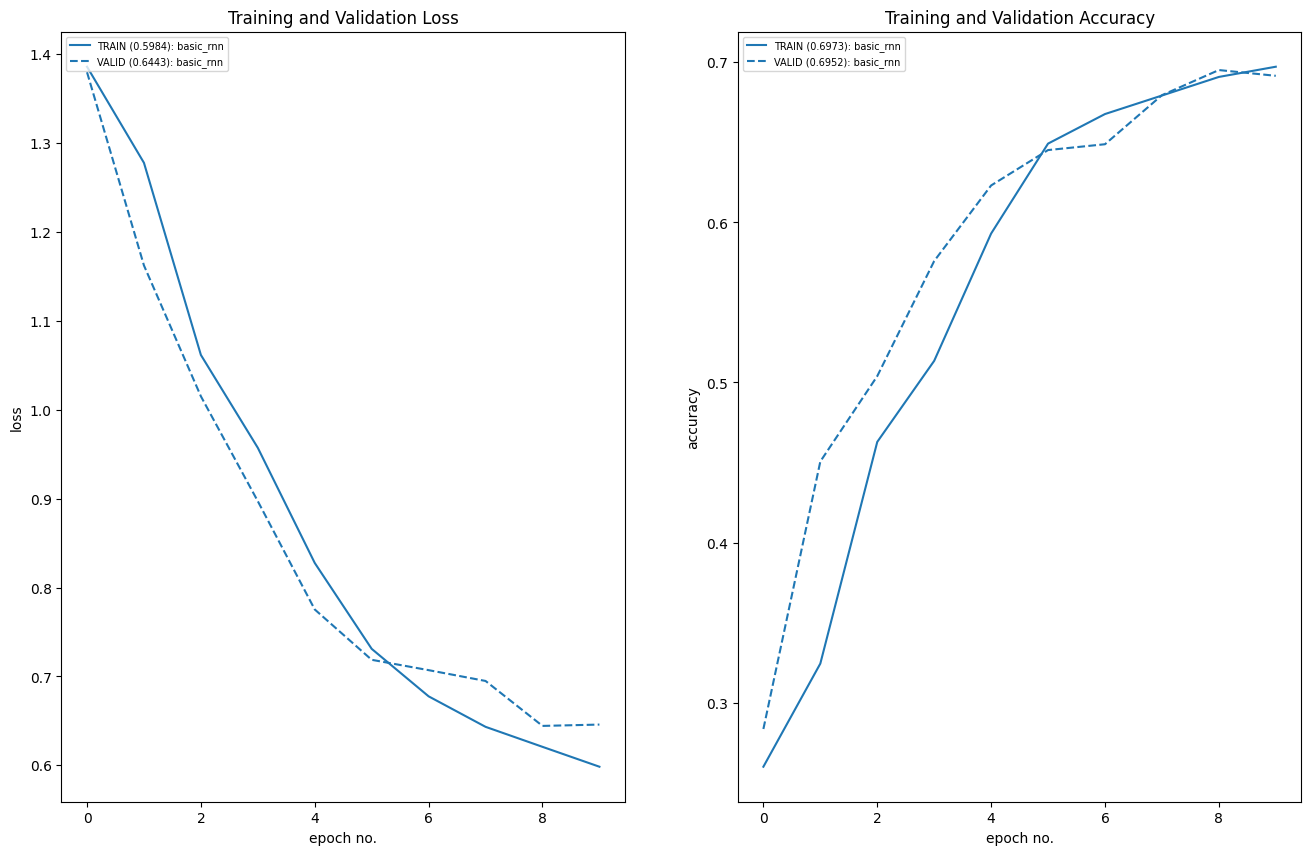

In [62]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['basic_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [63]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

In [64]:
Y_actual, Y_preds = MakePredictions(basic_rnn, test_loader)

In [65]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.6923684210526316

Classification Report : 
              precision    recall  f1-score   support

       World       0.86      0.81      0.83      1900
      Sports       0.91      0.96      0.93      1900
    Business       0.51      0.60      0.55      1900
    Sci/Tech       0.49      0.40      0.44      1900

    accuracy                           0.69      7600
   macro avg       0.69      0.69      0.69      7600
weighted avg       0.69      0.69      0.69      7600


Confusion Matrix : 
[[1531  135   78  156]
 [  58 1822    3   17]
 [  98   20 1149  633]
 [  83   24 1033  760]]


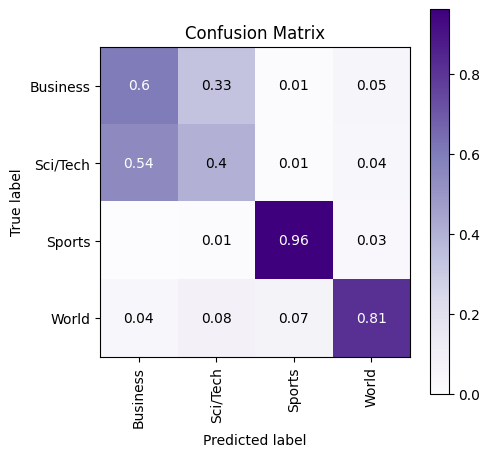

In [66]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Multiple RNN Layers
In this section, the approach involves enhancing the network architecture by stacking three recurrent layers instead of just one, aiming to improve the classification of text documents. The code remains largely similar to previous approaches, with minor adjustments, primarily setting the num_layers parameter of the RNN() constructor to 3 to indicate the stacking of three recurrent layers.

In [69]:
n_layers=3
n_hidden = 50

In [70]:
class StackedRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):

    super(StackedRnnClassifier, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.rnn = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, dropout=0.1)
    self.fc = nn.Linear(hidden_dim, output_dim)


  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    x, hidden = self.rnn(x, torch.randn(self.n_layers, len(X_batch), self.hidden_dim).to(device) ) #(3,1024,50)
    x = self.fc(x[:,-1]) # we only need the last op
    return x



In [71]:
stacked_rnn = StackedRnnClassifier(n_embedding, n_hidden, len(target_classes), n_layers)
stacked_rnn = stacked_rnn.to(device)

In [72]:
# driver setup
optimizer = optim.Adam(stacked_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [73]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(stacked_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(stacked_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3391941957554574 Avg Train Metric: 0.28103088751687844: 100%|██████████| 118/118 [00:07<00:00, 16.05it/s]
Avg Test Loss: 1.215328335762024 Avg Test Metric: 0.41975022479891777: 100%|██████████| 8/8 [00:00<00:00, 26.23it/s]


Epoch 1


Avg Train Loss: 1.0949087046970756 Avg Train Metric: 0.4543223300222623: 100%|██████████| 118/118 [00:06<00:00, 17.86it/s]
Avg Test Loss: 1.0018087774515152 Avg Test Metric: 0.5484463199973106: 100%|██████████| 8/8 [00:00<00:00, 16.85it/s]


Epoch 2


Avg Train Loss: 0.9214733864291239 Avg Train Metric: 0.563644374326124: 100%|██████████| 118/118 [00:11<00:00, 10.12it/s]
Avg Test Loss: 0.9050985500216484 Avg Test Metric: 0.5787132680416107: 100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Epoch 3


Avg Train Loss: 0.8004530264159381 Avg Train Metric: 0.6325926957494121: 100%|██████████| 118/118 [00:13<00:00,  8.88it/s]
Avg Test Loss: 0.7040553689002991 Avg Test Metric: 0.7254408970475197: 100%|██████████| 8/8 [00:00<00:00,  9.53it/s]


Epoch 4


Avg Train Loss: 0.62542049965616 Avg Train Metric: 0.7439594526412123: 100%|██████████| 118/118 [00:09<00:00, 12.20it/s]
Avg Test Loss: 0.5849510580301285 Avg Test Metric: 0.7972042411565781: 100%|██████████| 8/8 [00:00<00:00, 19.35it/s]


Epoch 5


Avg Train Loss: 0.505394636321876 Avg Train Metric: 0.8186237423096673: 100%|██████████| 118/118 [00:08<00:00, 13.38it/s]
Avg Test Loss: 0.49517589807510376 Avg Test Metric: 0.8233560249209404: 100%|██████████| 8/8 [00:00<00:00, 26.15it/s]


Epoch 6


Avg Train Loss: 0.4496115100080684 Avg Train Metric: 0.8433256730184717: 100%|██████████| 118/118 [00:07<00:00, 16.14it/s]
Avg Test Loss: 0.45093924179673195 Avg Test Metric: 0.8461092859506607: 100%|██████████| 8/8 [00:00<00:00, 25.37it/s]


Epoch 7


Avg Train Loss: 0.4041967528351283 Avg Train Metric: 0.8621370534775621: 100%|██████████| 118/118 [00:06<00:00, 18.17it/s]
Avg Test Loss: 0.4242720492184162 Avg Test Metric: 0.853519394993782: 100%|██████████| 8/8 [00:00<00:00, 25.43it/s]


Epoch 8


Avg Train Loss: 0.3771419762554815 Avg Train Metric: 0.8738644592842814: 100%|██████████| 118/118 [00:07<00:00, 16.14it/s]
Avg Test Loss: 0.4018315374851227 Avg Test Metric: 0.8635394275188446: 100%|██████████| 8/8 [00:00<00:00, 26.12it/s]


Epoch 9


Avg Train Loss: 0.348493810679953 Avg Train Metric: 0.8850787140555301: 100%|██████████| 118/118 [00:06<00:00, 18.29it/s]
Avg Test Loss: 0.42687102407217026 Avg Test Metric: 0.8608187437057495: 100%|██████████| 8/8 [00:00<00:00, 24.91it/s]


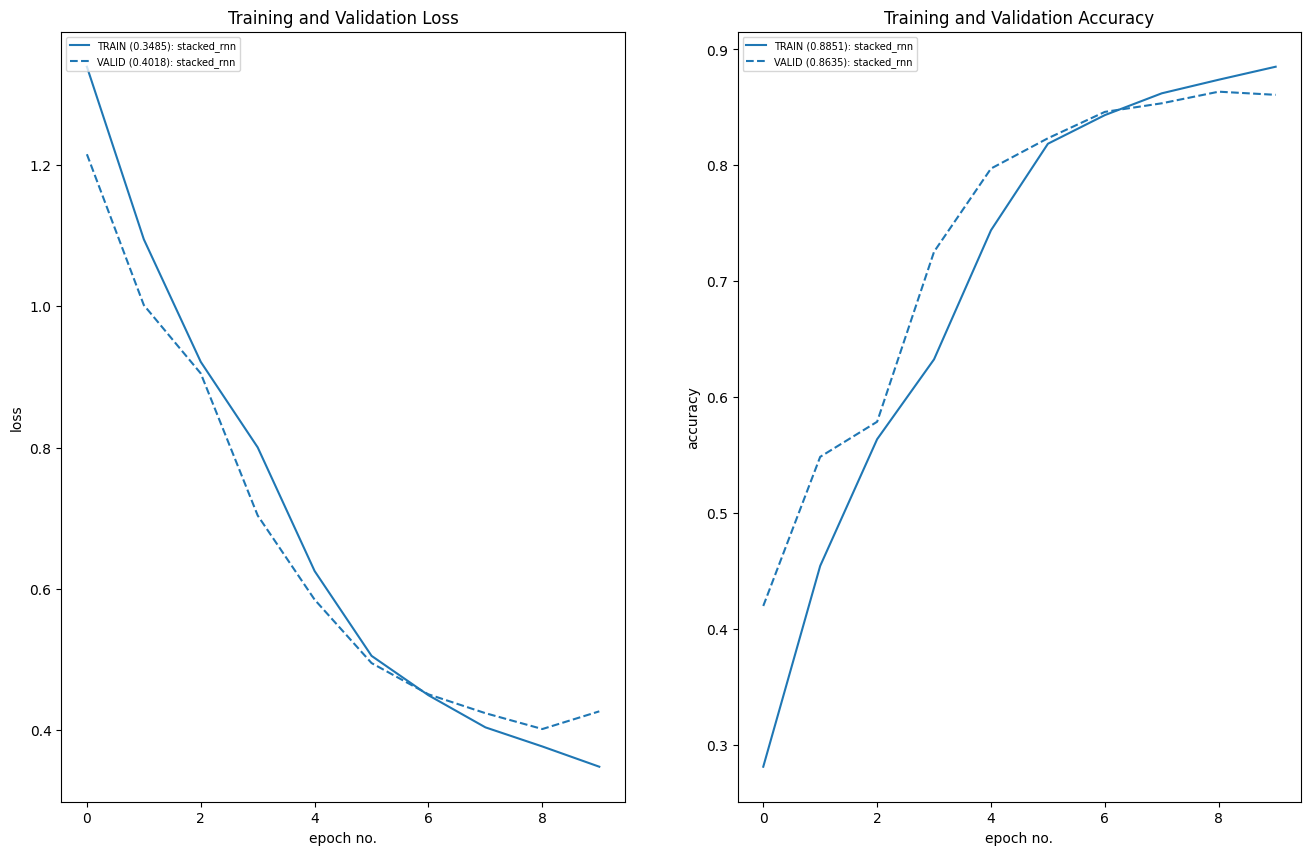

In [74]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['stacked_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [75]:
Y_actual, Y_preds = MakePredictions(stacked_rnn, test_loader)

In [76]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8586842105263158

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.84      0.87      1900
      Sports       0.92      0.96      0.94      1900
    Business       0.88      0.74      0.80      1900
    Sci/Tech       0.76      0.90      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600


Confusion Matrix : 
[[1594   72  126  108]
 [  42 1821    0   37]
 [  68   20 1406  406]
 [  63   60   72 1705]]


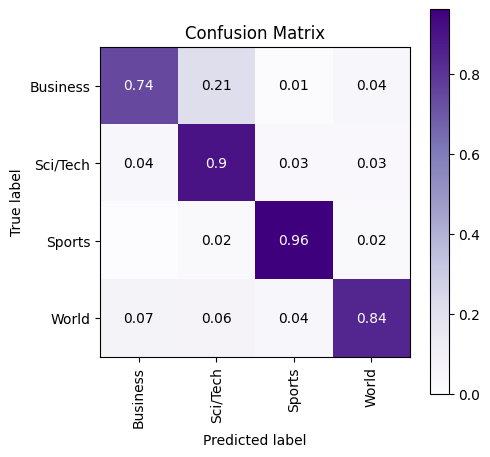

In [77]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Multiple Bidirectional RNN Layers
In this section, the approach mirrors the third one, utilizing three recurrent layers with the same output size. However, the key difference lies in the use of bidirectional recurrent layers. These layers operate both in the forward and backward directions through the input sequence. Consequently, when applied to a sequence of 50 tokens, the bidirectional recurrent layer processes both directions, effectively resulting in an output shape twice that of a unidirectional layer, as it outputs for both directions. The code remains largely unchanged from the third approach, with only minor adjustments to parameter values.

In [88]:
n_layers=3
n_hidden = 50

In [89]:
class BiStackeRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):

    super(BiStackeRnnClassifier, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.dropout = nn.Dropout(0.1)
    self.rnn = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim, num_layers = n_layers, batch_first = True, bidirectional=True)
    self.fc = nn.Linear(2 * hidden_dim, output_dim)  # due to bidirectional we mul by 2


  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    x, hidden = self.rnn(x, torch.randn(2 * self.n_layers, len(X_batch), self.hidden_dim).to(device) ) #(6,1024,50)
    x = self.fc(x[:,-1]) # we only need the last op
    return x



In [90]:
bi_stacked_rnn = BiStackeRnnClassifier(n_embedding, n_hidden, len(target_classes), n_layers)
bi_stacked_rnn = bi_stacked_rnn.to(device)

In [91]:
# driver setup
optimizer = optim.Adam(bi_stacked_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [92]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(bi_stacked_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(bi_stacked_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3807286013991147 Avg Train Metric: 0.26974456542629305: 100%|██████████| 118/118 [00:10<00:00, 11.60it/s]
Avg Test Loss: 1.3809219747781754 Avg Test Metric: 0.2767268978059292: 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]


Epoch 1


Avg Train Loss: 1.3760802664999234 Avg Train Metric: 0.28186696212170487: 100%|██████████| 118/118 [00:14<00:00,  8.19it/s]
Avg Test Loss: 1.3638452887535095 Avg Test Metric: 0.3124310150742531: 100%|██████████| 8/8 [00:00<00:00,  9.89it/s]


Epoch 2


Avg Train Loss: 1.3269324514825465 Avg Train Metric: 0.32642167099451613: 100%|██████████| 118/118 [00:13<00:00,  8.60it/s]
Avg Test Loss: 1.3313059359788895 Avg Test Metric: 0.35389356315135956: 100%|██████████| 8/8 [00:01<00:00,  5.82it/s]


Epoch 3


Avg Train Loss: 1.3515633405265162 Avg Train Metric: 0.3406687851174403: 100%|██████████| 118/118 [00:14<00:00,  8.05it/s]
Avg Test Loss: 1.306475207209587 Avg Test Metric: 0.38078299537301064: 100%|██████████| 8/8 [00:00<00:00, 13.75it/s]


Epoch 4


Avg Train Loss: 1.1866029642396054 Avg Train Metric: 0.3986291706056918: 100%|██████████| 118/118 [00:14<00:00,  8.37it/s]
Avg Test Loss: 1.096441000699997 Avg Test Metric: 0.4666595943272114: 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]


Epoch 5


Avg Train Loss: 1.0414748085757433 Avg Train Metric: 0.4738461238853002: 100%|██████████| 118/118 [00:15<00:00,  7.74it/s]
Avg Test Loss: 1.0127153247594833 Avg Test Metric: 0.4861138388514519: 100%|██████████| 8/8 [00:00<00:00, 13.05it/s]


Epoch 6


Avg Train Loss: 0.9741668706223116 Avg Train Metric: 0.5036857539819459: 100%|██████████| 118/118 [00:14<00:00,  8.35it/s]
Avg Test Loss: 0.9775545001029968 Avg Test Metric: 0.49550479650497437: 100%|██████████| 8/8 [00:00<00:00,  9.24it/s]


Epoch 7


Avg Train Loss: 0.9311912822521339 Avg Train Metric: 0.526450281426058: 100%|██████████| 118/118 [00:12<00:00,  9.17it/s]
Avg Test Loss: 0.9691942483186722 Avg Test Metric: 0.5007046759128571: 100%|██████████| 8/8 [00:00<00:00, 13.79it/s]


Epoch 8


Avg Train Loss: 0.9083262287964255 Avg Train Metric: 0.5404169458453938: 100%|██████████| 118/118 [00:12<00:00,  9.64it/s]
Avg Test Loss: 0.9015181362628937 Avg Test Metric: 0.5647419989109039: 100%|██████████| 8/8 [00:00<00:00, 24.38it/s]


Epoch 9


Avg Train Loss: 0.9404409199447955 Avg Train Metric: 0.5738195701170776: 100%|██████████| 118/118 [00:15<00:00,  7.67it/s]
Avg Test Loss: 0.9985257461667061 Avg Test Metric: 0.5248391032218933: 100%|██████████| 8/8 [00:00<00:00, 24.19it/s]


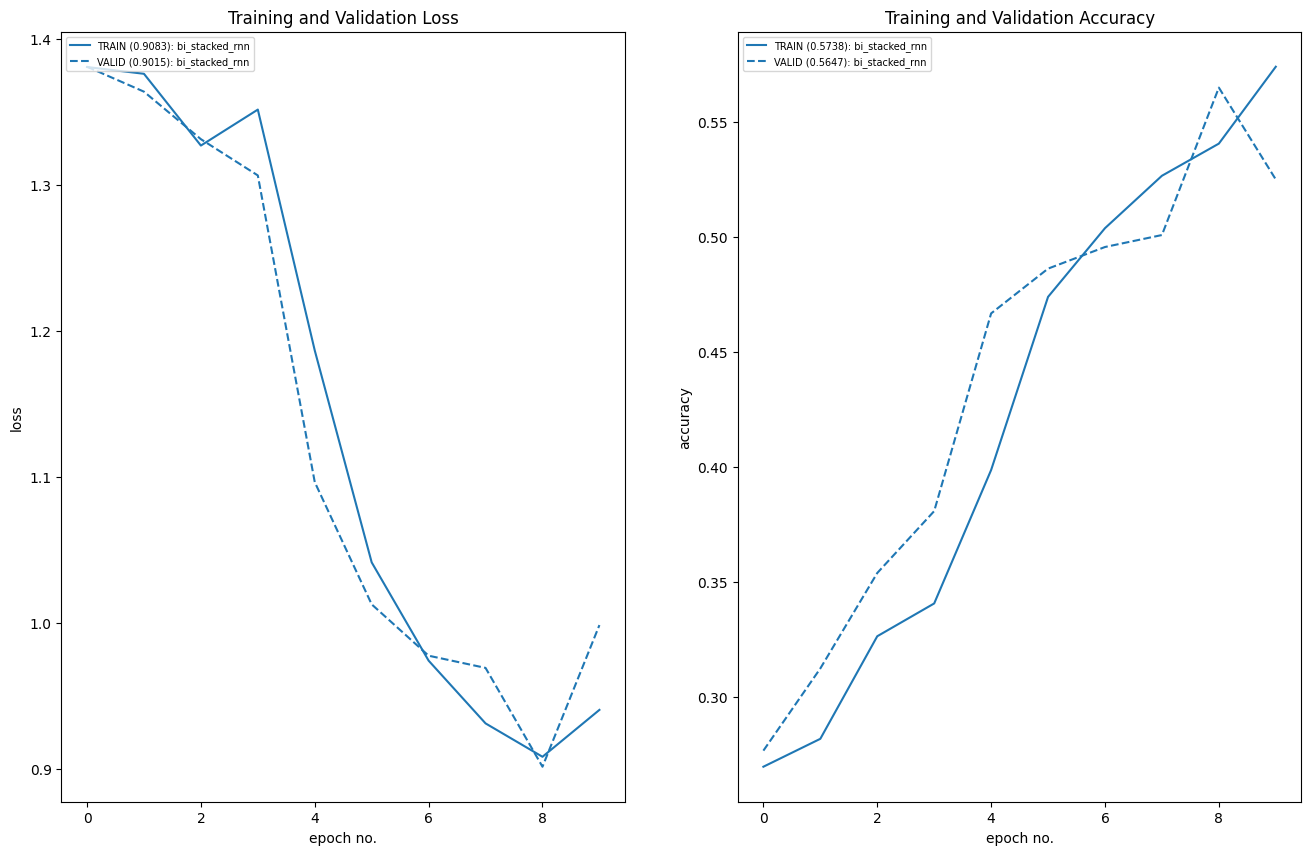

In [93]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['bi_stacked_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [94]:
# predictions
Y_actual, Y_preds = MakePredictions(bi_stacked_rnn, test_loader)

In [95]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.5310526315789473

Classification Report : 
              precision    recall  f1-score   support

       World       0.45      0.15      0.22      1900
      Sports       0.85      0.94      0.89      1900
    Business       0.39      0.77      0.52      1900
    Sci/Tech       0.45      0.27      0.33      1900

    accuracy                           0.53      7600
   macro avg       0.54      0.53      0.49      7600
weighted avg       0.54      0.53      0.49      7600


Confusion Matrix : 
[[ 276  100 1218  306]
 [   8 1788   29   75]
 [ 161   47 1468  224]
 [ 165  162 1069  504]]


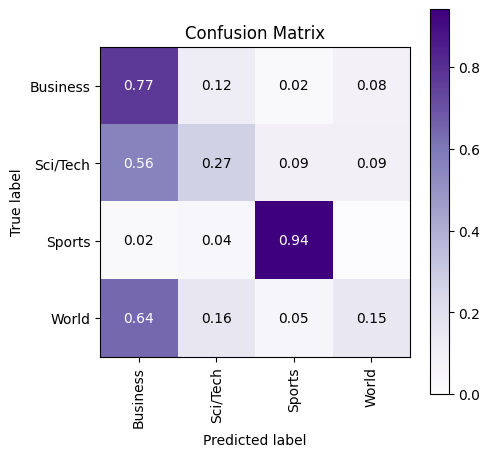

In [96]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Stacking Multiple RNN Layers
In this section, three recurrent layers are defined with output sizes of 50, 60, and 75 respectively. The output of the embedding layer feeds into the first recurrent layer, then into the second, and finally into the third recurrent layer successively. The output of the last recurrent layer is then passed to a linear layer for prediction by the network.

In [107]:
hidden_dim_ls = [50, 60, 75]
n_layers = 1

In [116]:
class StackeRnnClassifier(nn.Module):
  def __init__(self, embedding_dim, hidden_dim_ls, output_dim, n_layers):
    super(StackeRnnClassifier, self).__init__()
    self.n_layers = n_layers
    self.embedding = nn.Embedding(len(vocab), embedding_dim)
    self.rnn1 = nn.RNN(input_size = embedding_dim , hidden_size = hidden_dim_ls[0], num_layers = n_layers, batch_first = True)
    self.rnn2 = nn.RNN(input_size = hidden_dim_ls[0] , hidden_size = hidden_dim_ls[1], num_layers = n_layers, batch_first = True)
    self.rnn3 = nn.RNN(input_size = hidden_dim_ls[1] , hidden_size = hidden_dim_ls[2], num_layers = n_layers, batch_first = True)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(hidden_dim_ls[2], output_dim)


  def forward(self, X_batch):
    embeddings = self.embedding(X_batch)
    embeddings = self.dropout(embeddings)
    rnn1_out, hidden = self.rnn1(embeddings, torch.randn(self.n_layers, len(X_batch), hidden_dim_ls[0]).to(device))
    rnn2_out, hidden = self.rnn2(rnn1_out, torch.randn(self.n_layers, len(X_batch), hidden_dim_ls[1]).to(device))
    rnn3_out, hidden = self.rnn3(rnn2_out, torch.randn(self.n_layers, len(X_batch), hidden_dim_ls[2]).to(device))
    x = self.fc(rnn3_out[:,-1])
    return x


In [117]:
multi_stacked_rnn = StackeRnnClassifier(n_embedding, hidden_dim_ls, len(target_classes), n_layers)
multi_stacked_rnn = multi_stacked_rnn.to(device)

In [118]:
# driver setup
optimizer = optim.Adam(multi_stacked_rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [119]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(multi_stacked_rnn, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(multi_stacked_rnn, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3150992969335136 Avg Train Metric: 0.2900760923906908: 100%|██████████| 118/118 [00:06<00:00, 17.74it/s]
Avg Test Loss: 1.1358262300491333 Avg Test Metric: 0.44621145725250244: 100%|██████████| 8/8 [00:00<00:00, 24.43it/s]


Epoch 1


Avg Train Loss: 1.0677030606795166 Avg Train Metric: 0.4581923277701362: 100%|██████████| 118/118 [00:07<00:00, 15.91it/s]
Avg Test Loss: 0.9999281167984009 Avg Test Metric: 0.5015055239200592: 100%|██████████| 8/8 [00:00<00:00, 25.95it/s]


Epoch 2


Avg Train Loss: 0.933345074370756 Avg Train Metric: 0.5344856479915522: 100%|██████████| 118/118 [00:07<00:00, 16.61it/s]
Avg Test Loss: 0.8348622471094131 Avg Test Metric: 0.6476082056760788: 100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


Epoch 3


Avg Train Loss: 0.7323531867083857 Avg Train Metric: 0.6826458042961056: 100%|██████████| 118/118 [00:06<00:00, 18.17it/s]
Avg Test Loss: 0.6210557371377945 Avg Test Metric: 0.7812211290001869: 100%|██████████| 8/8 [00:00<00:00, 26.24it/s]


Epoch 4


Avg Train Loss: 0.5636877990880255 Avg Train Metric: 0.7870435068162821: 100%|██████████| 118/118 [00:07<00:00, 15.85it/s]
Avg Test Loss: 0.5215169861912727 Avg Test Metric: 0.8117684125900269: 100%|██████████| 8/8 [00:00<00:00, 25.60it/s]


Epoch 5


Avg Train Loss: 0.48252359765060876 Avg Train Metric: 0.8273439563937106: 100%|██████████| 118/118 [00:07<00:00, 16.81it/s]
Avg Test Loss: 0.5011591352522373 Avg Test Metric: 0.8205364868044853: 100%|██████████| 8/8 [00:00<00:00, 14.09it/s]


Epoch 6


Avg Train Loss: 0.4345590085801432 Avg Train Metric: 0.8458321246050172: 100%|██████████| 118/118 [00:07<00:00, 15.96it/s]
Avg Test Loss: 0.4358811303973198 Avg Test Metric: 0.8428281471133232: 100%|██████████| 8/8 [00:00<00:00, 25.52it/s]


Epoch 7


Avg Train Loss: 0.39402676462116887 Avg Train Metric: 0.8639471152071225: 100%|██████████| 118/118 [00:07<00:00, 16.25it/s]
Avg Test Loss: 0.41992537304759026 Avg Test Metric: 0.8582998365163803: 100%|██████████| 8/8 [00:00<00:00, 26.11it/s]


Epoch 8


Avg Train Loss: 0.36689150510197976 Avg Train Metric: 0.8749026408640005: 100%|██████████| 118/118 [00:06<00:00, 17.60it/s]
Avg Test Loss: 0.42538123577833176 Avg Test Metric: 0.8612030819058418: 100%|██████████| 8/8 [00:00<00:00, 25.82it/s]


Epoch 9


Avg Train Loss: 0.34317477830385756 Avg Train Metric: 0.8849546570899123: 100%|██████████| 118/118 [00:07<00:00, 16.23it/s]
Avg Test Loss: 0.3992154598236084 Avg Test Metric: 0.862682156264782: 100%|██████████| 8/8 [00:00<00:00, 26.46it/s]


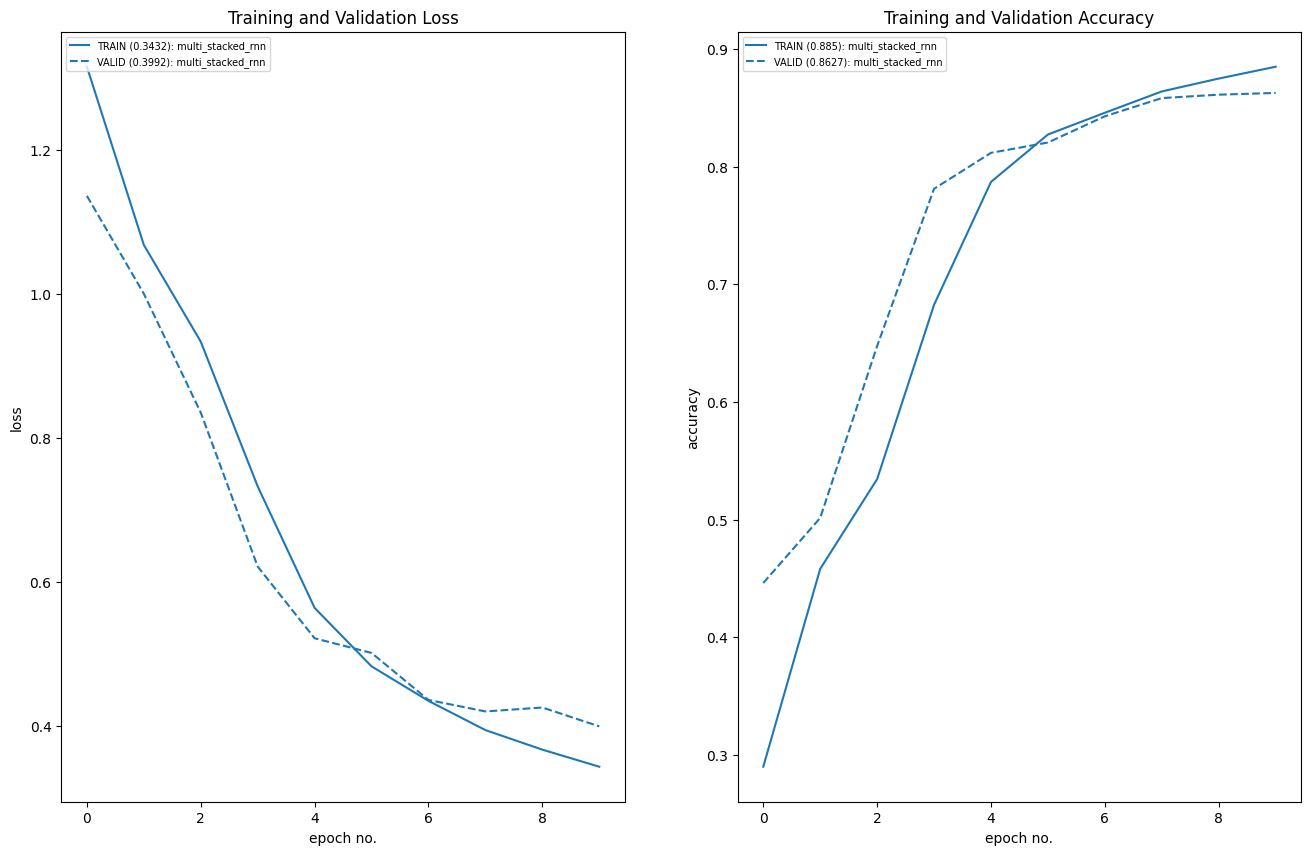

In [120]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['multi_stacked_rnn'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [125]:
# predictions
Y_actual, Y_preds = MakePredictions(multi_stacked_rnn, test_loader)

In [126]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8690789473684211

Classification Report : 
              precision    recall  f1-score   support

       World       0.91      0.84      0.87      1900
      Sports       0.93      0.96      0.94      1900
    Business       0.79      0.86      0.82      1900
    Sci/Tech       0.85      0.82      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600


Confusion Matrix : 
[[1594   72  189   45]
 [  34 1820    5   41]
 [  64   14 1628  194]
 [  55   50  232 1563]]


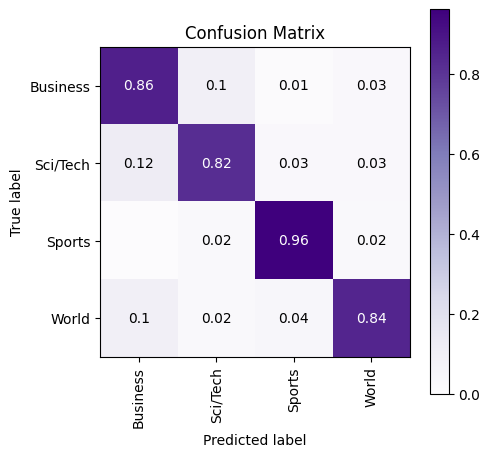

In [127]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Model Explanation by LIME
First, retrieve all text examples from the test dataset. Then, create an instance of LimeTextExplainer with the target labels. Define a function required by explain_instance() method. This function takes a list of text examples as input and returns prediction probabilities. It tokenizes and vectorizes data before feeding it to the network for predictions. The network's output is converted to probabilities using softmax activation function before being returned.

In [139]:
max_words = 50

In [140]:
X_test_text, Y_test = [], []
for Y, X in test_dataset:
    X_test_text.append(X)
    Y_test.append(Y-1)

len(X_test_text)

7600

In [150]:
from lime import lime_text
import numpy as np

explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True, random_state=42)

def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = multi_stacked_rnn(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.cpu().detach().numpy()

In [155]:
rng = np.random.RandomState()
idx = rng.randint(1, len(X_test_text))
print(X_test_text[idx])
print(Y_test[idx])

A Card to Your Future 401(k) credit card would give millions of American workers the chance to borrow their own money from their retirement savings plans.
2


In [156]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,
                                         labels=Y_test[idx:idx+1])
explanation.show_in_notebook()

Intercept 0.21966015513107512
Prediction_local [0.74843836]
Right: 0.78429663


References:

https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-rnn-for-text-classification-tasks
https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions
https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach
https://coderzcolumn.com/tutorials/machine-learning/how-to-use-eli5-to-understand-sklearn-models-their-performance-and-their-predictions
https://coderzcolumn.com/tutorials/artificial-intelligence/captum-interpret-predictions-of-pytorch-networks
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html